# Import and Upload

In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
# upload
uploaded = files.upload()

Saving deflator_yearly_agg.csv to deflator_yearly_agg.csv
Saving general_cpi_monthly_agg.csv to general_cpi_monthly_agg.csv
Saving TCI_monthly_agg.csv to TCI_monthly_agg.csv


# General CPI - monthly

In [3]:
df_cpi = pd.read_csv('general_cpi_monthly_agg.csv')
df_cpi.head()

,EXTRACTIONDATE,REG,Descripción series,Date (varchar),Date (#),IPC,YEAR,MONTH,LIKELIHOODOFDEFAULT,DATE
0,2024-03-21 21:55:32.380,1.0,IPC general (empalme BCCh),Jan.2009,2009-01-01,59.05,2009,1,0.052036,2009-01-01
1,2024-03-21 21:55:32.380,1.0,IPC general (empalme BCCh),Feb.2009,2009-02-01,58.28,2009,2,0.050888,2009-02-01
2,2024-03-21 21:55:32.380,1.0,IPC general (empalme BCCh),Mar.2009,2009-03-01,58.30,2009,3,0.050589,2009-03-01
3,2024-03-21 21:55:32.380,1.0,IPC general (empalme BCCh),Apr.2009,2009-04-01,58.21,2009,4,0.058679,2009-04-01
4,2024-03-21 21:55:32.380,1.0,IPC general (empalme BCCh),May.2009,2009-05-01,58.09,2009,5,0.065349,2009-05-01


In [4]:
# check if there is missing value
is_na_present = df_cpi.isna().any().any()
print(f"There is any NA values in the DataFrame - {is_na_present}")

There is any NA values in the DataFrame - False


In [5]:
df_cpi.dtypes

EXTRACTIONDATE          object
REG                    float64
Descripción series      object
Date (varchar)          object
Date (#)                object
IPC                    float64
YEAR                     int64
MONTH                    int64
LIKELIHOODOFDEFAULT    float64
DATE                    object
dtype: object

In [6]:
# pick only CPI and Default Likelihood
df_cpi_corr = df_cpi[['IPC', 'LIKELIHOODOFDEFAULT']]
df_cpi_corr.head()

,IPC,LIKELIHOODOFDEFAULT
0,59.05,0.052036
1,58.28,0.050888
2,58.30,0.050589
3,58.21,0.058679
4,58.09,0.065349


Basic Visualization

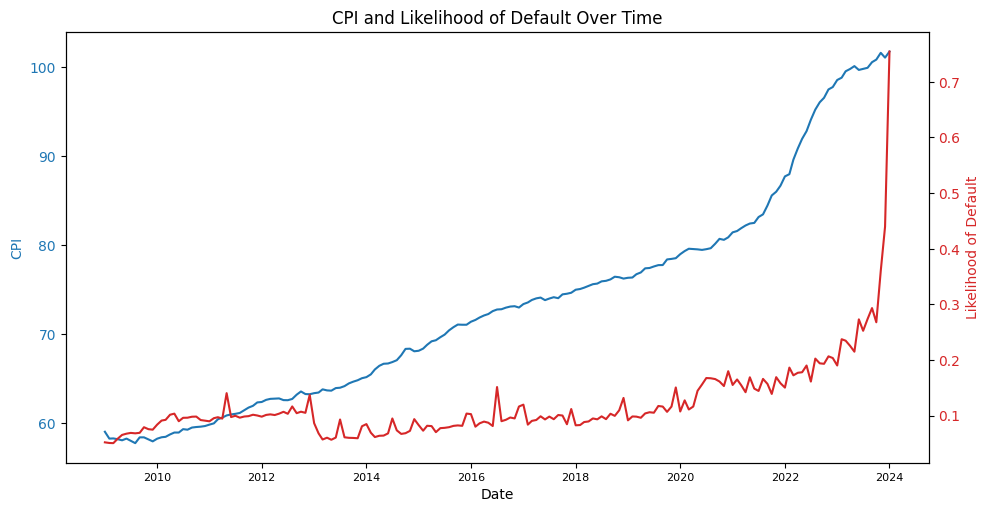

In [7]:
# CPI and Likelihood of Default Over Time

# Convert 'Date (#)' column to datetime format
df_cpi['Date (#)'] = pd.to_datetime(df_cpi['Date (#)'])

fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('CPI', color=color)
ax1.plot(df_cpi['Date (#)'], df_cpi['IPC'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax1.tick_params(axis='x', labelsize=8)

ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Likelihood of Default', color=color)  # We already handled the x-label with ax1
ax2.plot(df_cpi['Date (#)'], df_cpi['LIKELIHOODOFDEFAULT'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # To ensure tight layout so labels are not cut off
plt.title('CPI and Likelihood of Default Over Time')
plt.xticks(rotation=45)
plt.show()

Regression

In [8]:
# Compute the Pearson correlation coefficient
corr_coef = np.corrcoef(df_cpi_corr['IPC'], df_cpi_corr['LIKELIHOODOFDEFAULT'])[0, 1]

# Prepare data for OLS regression
X = df_cpi_corr['IPC']
X = sm.add_constant(X)  # adding a constant to the model
y = df_cpi_corr['LIKELIHOODOFDEFAULT']

# Fit OLS model
cpi_model = sm.OLS(y, X).fit()

# Print the summary of the OLS model
print(cpi_model.summary())

                             OLS Regression Results                            
Dep. Variable:     LIKELIHOODOFDEFAULT   R-squared:                       0.543
Model:                             OLS   Adj. R-squared:                  0.541
Method:                  Least Squares   F-statistic:                     212.9
Date:                 Tue, 02 Apr 2024   Prob (F-statistic):           2.81e-32
Time:                         23:43:29   Log-Likelihood:                 286.23
No. Observations:                  181   AIC:                            -568.5
Df Residuals:                      179   BIC:                            -562.1
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2104      0.023     -9.16

In [9]:
# Print the result
print(f"Model Pearson Correlation Coefficient: {corr_coef}")
print("Model R-squared: {:.3f}".format(cpi_model.rsquared))

print("\nModel Coefficients:")
print(f"Intercept: {cpi_model.params[0]:.3f}")
print(f"Slope (CPI): {cpi_model.params[1]:.3f}")

print("\nModel P-values:")
print(f"P-value (Intercept): {cpi_model.pvalues[0]:.3f}")
print(f"P-value (CPI): {cpi_model.pvalues[1]:.3f}")

print("\nModel Standard Errors:")
print(f"Standard Error (Intercept): {cpi_model.bse[0]:.3f}")
print(f"Standard Error (CPI): {cpi_model.bse[1]:.3f}")

Model Pearson Correlation Coefficient: 0.7370409599689881
Model R-squared: 0.543

Model Coefficients:
Intercept: -0.210
Slope (CPI): 0.005

Model P-values:
P-value (Intercept): 0.000
P-value (CPI): 0.000

Model Standard Errors:
Standard Error (Intercept): 0.023
Standard Error (CPI): 0.000


Regression Visualization

In [10]:
sns.set_style("whitegrid")

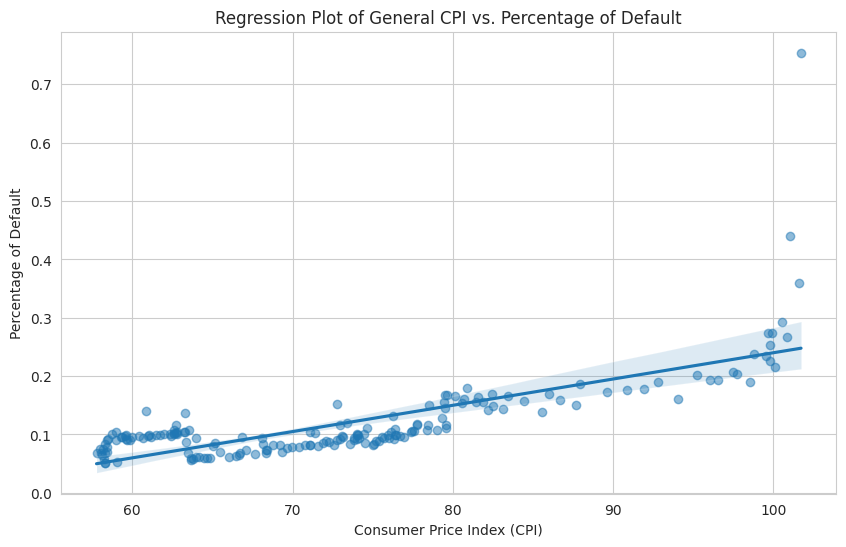

In [11]:
# Regression Plot
plt.figure(figsize=(10, 6))
sns.regplot(x='IPC', y='LIKELIHOODOFDEFAULT', data=df_cpi_corr, scatter_kws={'alpha':0.5})
plt.title('Regression Plot of General CPI vs. Percentage of Default')
plt.xlabel('Consumer Price Index (CPI)')
plt.ylabel('Percentage of Default')
plt.show()

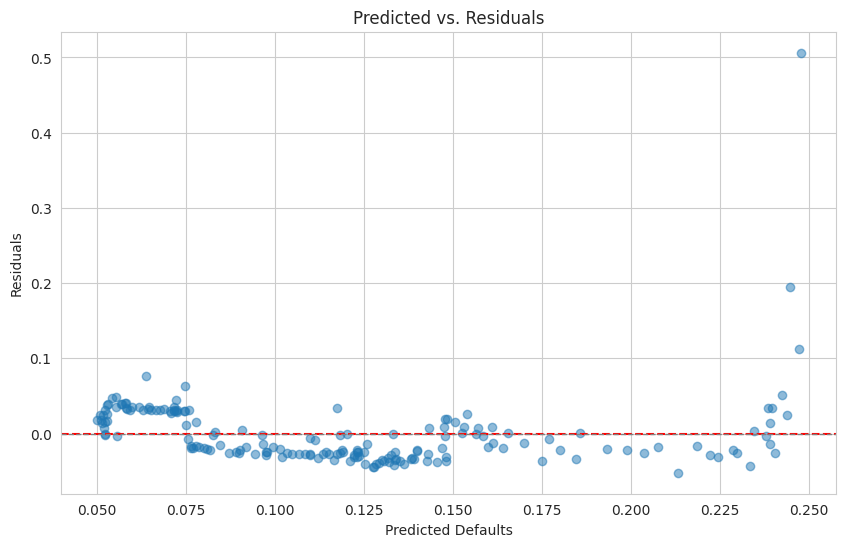

In [12]:
# Residual Plot
residuals = cpi_model.resid
predicted = cpi_model.fittedvalues

# Creating the plot
plt.figure(figsize=(10, 6))
plt.scatter(predicted, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Predicted vs. Residuals')
plt.xlabel('Predicted Defaults')
plt.ylabel('Residuals')

# Adding a zero line for reference
plt.axhline(0, linestyle='--', color='grey', linewidth=1)

plt.show()

Autocorrelation and Partial Autocorrelation Visualization

<Figure size 1000x600 with 0 Axes>

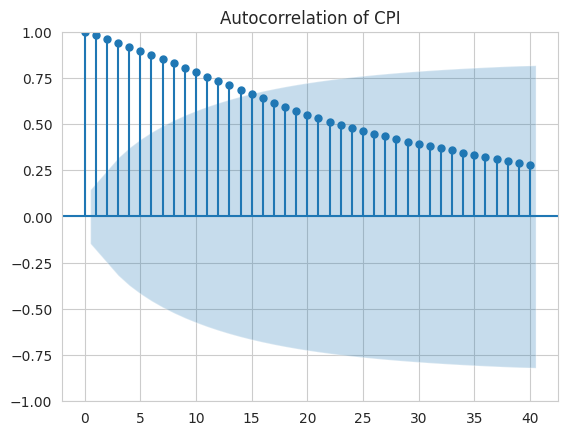

<Figure size 1000x600 with 0 Axes>

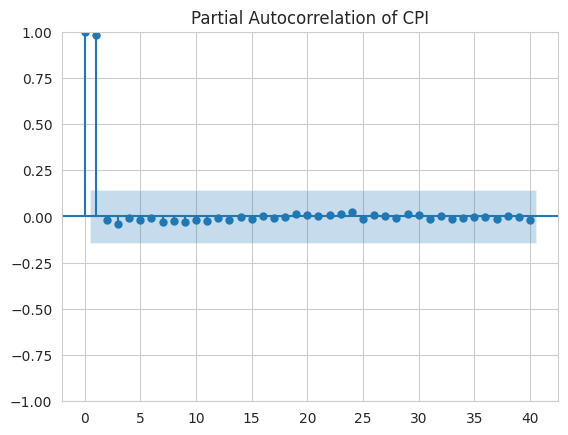

In [13]:
# Autocorrelation and Partial Autocorrelation
df_cpi.set_index('Date (#)', inplace=True)

# Autocorrelation Plot for CPI
plt.figure(figsize=(10, 6))
plot_acf(df_cpi['IPC'], lags=40)
plt.title('Autocorrelation of CPI')
plt.show()

# Partial Autocorrelation Plot for CPI
plt.figure(figsize=(10, 6))
plot_pacf(df_cpi['IPC'], lags=40, method='ywm')
plt.title('Partial Autocorrelation of CPI')
plt.show()

<Figure size 1000x600 with 0 Axes>

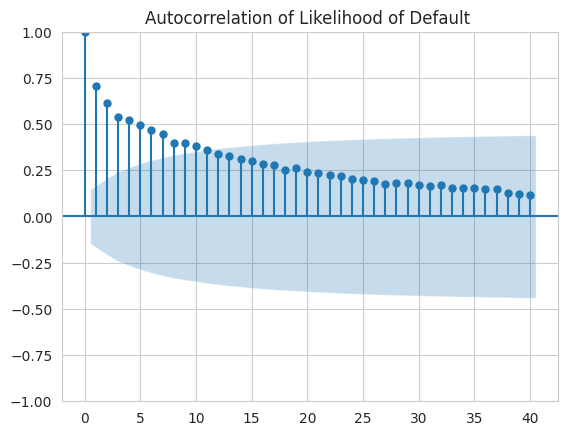

<Figure size 1000x600 with 0 Axes>

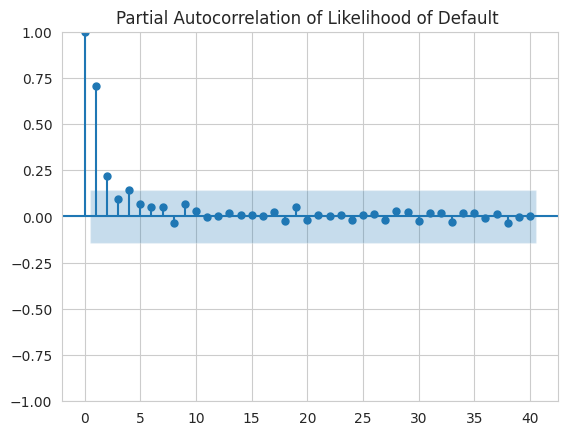

In [14]:
# Autocorrelation Plot for Likelihood of Default
plt.figure(figsize=(10, 6))
plot_acf(df_cpi['LIKELIHOODOFDEFAULT'], lags=40)
plt.title('Autocorrelation of Likelihood of Default ')
plt.show()

# Partial Autocorrelation Plot for CPI
plt.figure(figsize=(10, 6))
plot_pacf(df_cpi['LIKELIHOODOFDEFAULT'], lags=40, method='ywm')
plt.title('Partial Autocorrelation of Likelihood of Default ')
plt.show()

# GDP Deflator - yearly

In [15]:
df_deflator = pd.read_csv('deflator_yearly_agg.csv')
df_deflator.head()

,EXTRACTIONDATE,Country Name,YEAR,DATE,deflator(annual%),LIKELIHOODOFDEFAULT
0,2024-03-23,Chile,2006,2006-12-31,12.349896,0.032722
1,2024-03-23,Chile,2007,2007-12-31,5.088757,0.048319
2,2024-03-23,Chile,2008,2008-12-31,0.311133,0.057514
3,2024-03-23,Chile,2009,2009-12-31,3.577795,0.065448
4,2024-03-23,Chile,2010,2010-12-31,8.857441,0.094427


In [16]:
# check if there is missing value
is_na_present = df_deflator.isna().any().any()
print(f"There is any NA values in the DataFrame - {is_na_present}")

There is any NA values in the DataFrame - False


In [17]:
df_deflator.dtypes

EXTRACTIONDATE          object
Country Name            object
YEAR                     int64
DATE                    object
deflator(annual%)      float64
LIKELIHOODOFDEFAULT    float64
dtype: object

In [18]:
# pick only GDP Deflator and Default Likelihood
df_dfl_corr = df_deflator[['deflator(annual%)', 'LIKELIHOODOFDEFAULT']]
df_dfl_corr.head()

,deflator(annual%),LIKELIHOODOFDEFAULT
0,12.349896,0.032722
1,5.088757,0.048319
2,0.311133,0.057514
3,3.577795,0.065448
4,8.857441,0.094427


Basic Visualization

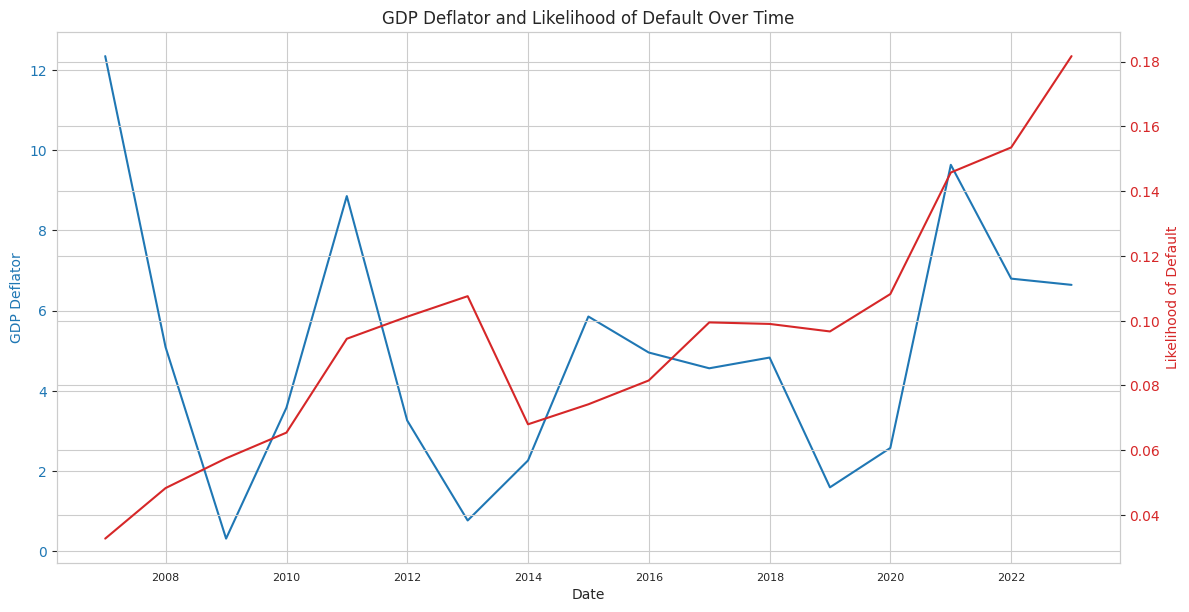

In [19]:
# GDP Deflator and Likelihood of Default Over Time

# Convert 'Date' column to datetime format
df_deflator['DATE'] = pd.to_datetime(df_deflator['DATE'])

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('GDP Deflator', color=color)
ax1.plot(df_deflator['DATE'], df_deflator['deflator(annual%)'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax1.tick_params(axis='x', labelsize=8)

ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Likelihood of Default', color=color)  # We already handled the x-label with ax1
ax2.plot(df_deflator['DATE'], df_deflator['LIKELIHOODOFDEFAULT'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # To ensure tight layout so labels are not cut off
plt.title('GDP Deflator and Likelihood of Default Over Time')
plt.xticks(rotation=45)
plt.show()

Regression

In [20]:
# Compute the Pearson correlation coefficient
corr_coef = np.corrcoef(df_dfl_corr['deflator(annual%)'], df_dfl_corr['LIKELIHOODOFDEFAULT'])[0, 1]

# Prepare data for OLS regression
X = df_dfl_corr['deflator(annual%)']
X = sm.add_constant(X)  # adding a constant to the model
y = df_dfl_corr['LIKELIHOODOFDEFAULT']

# Fit OLS model
dfl_model = sm.OLS(y, X).fit()

# Print the summary of the OLS model
print(dfl_model.summary())

                             OLS Regression Results                            
Dep. Variable:     LIKELIHOODOFDEFAULT   R-squared:                       0.009
Model:                             OLS   Adj. R-squared:                 -0.057
Method:                  Least Squares   F-statistic:                    0.1367
Date:                 Tue, 02 Apr 2024   Prob (F-statistic):              0.717
Time:                         23:43:41   Log-Likelihood:                 31.881
No. Observations:                   17   AIC:                            -59.76
Df Residuals:                       15   BIC:                            -58.10
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0894

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [21]:
# Print the result
print(f"Model Pearson Correlation Coefficient: {corr_coef}")
print("Model R-squared: {:.3f}".format(dfl_model.rsquared))

print("\nModel Coefficients:")
print(f"Intercept: {dfl_model.params[0]:.3f}")
print(f"Slope (GDP Deflator): {dfl_model.params[1]:.3f}")

print("\nModel P-values:")
print(f"P-value (Intercept): {dfl_model.pvalues[0]:.3f}")
print(f"P-value (GDP Deflator): {dfl_model.pvalues[1]:.3f}")

print("\nModel Standard Errors:")
print(f"Standard Error (Intercept): {dfl_model.bse[0]:.3f}")
print(f"Standard Error (GDP Deflator): {dfl_model.bse[1]:.3f}")

Model Pearson Correlation Coefficient: 0.09504641292152619
Model R-squared: 0.009

Model Coefficients:
Intercept: 0.089
Slope (GDP Deflator): 0.001

Model P-values:
P-value (Intercept): 0.000
P-value (GDP Deflator): 0.717

Model Standard Errors:
Standard Error (Intercept): 0.018
Standard Error (GDP Deflator): 0.003


Regression Visualization

In [22]:
sns.set_style("whitegrid")

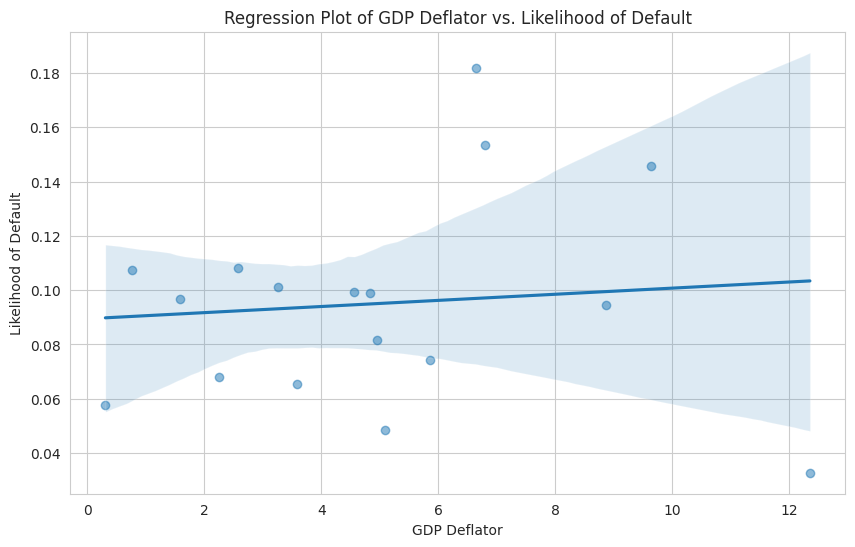

In [23]:
# Regression Plot
plt.figure(figsize=(10, 6))
sns.regplot(x='deflator(annual%)', y='LIKELIHOODOFDEFAULT', data=df_dfl_corr, scatter_kws={'alpha':0.5})
plt.title('Regression Plot of GDP Deflator vs. Likelihood of Default')
plt.xlabel('GDP Deflator')
plt.ylabel('Likelihood of Default')
plt.show()

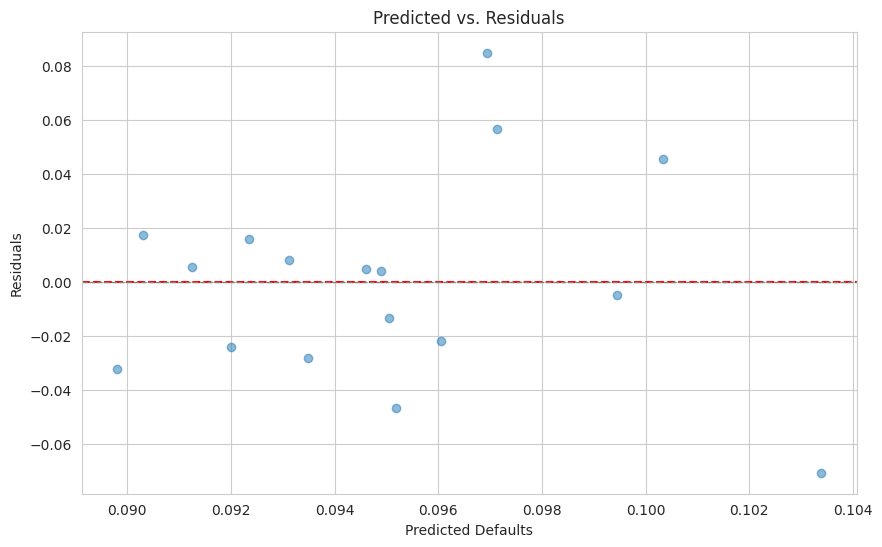

In [24]:
# Residual Plot
residuals = dfl_model.resid
predicted = dfl_model.fittedvalues

# Creating the plot
plt.figure(figsize=(10, 6))
plt.scatter(predicted, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Predicted vs. Residuals')
plt.xlabel('Predicted Defaults')
plt.ylabel('Residuals')

# Adding a zero line for reference
plt.axhline(0, linestyle='--', color='grey', linewidth=1)

plt.show()

Autocorrelation and Partial Autocorrelation Visualization

<Figure size 1000x600 with 0 Axes>

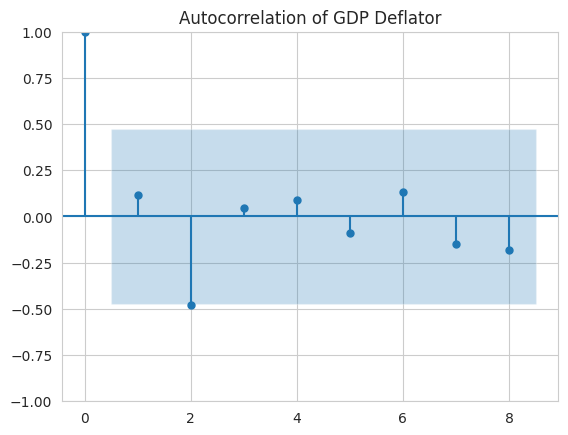

<Figure size 1000x600 with 0 Axes>

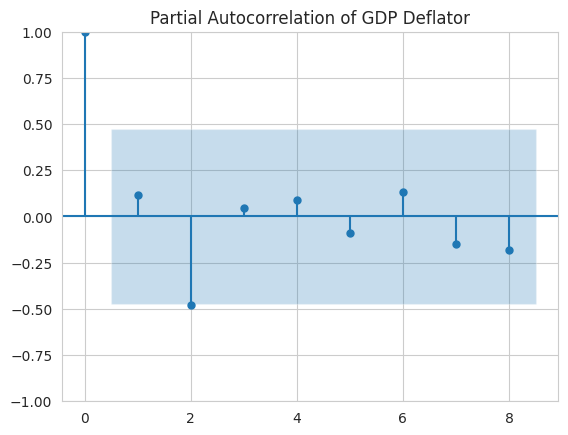

In [25]:
# Autocorrelation and Partial Autocorrelation
df_deflator.set_index('DATE', inplace=True)

# Autocorrelation Plot for GDP Deflator
plt.figure(figsize=(10, 6))
plot_pacf(df_deflator['deflator(annual%)'], lags=8)
plt.title('Autocorrelation of GDP Deflator')
plt.show()

# Partial Autocorrelation Plot for GDP Deflator
plt.figure(figsize=(10, 6))
plot_pacf(df_deflator['deflator(annual%)'], lags=8, method='ywm')
plt.title('Partial Autocorrelation of GDP Deflator')
plt.show()

<Figure size 1000x600 with 0 Axes>

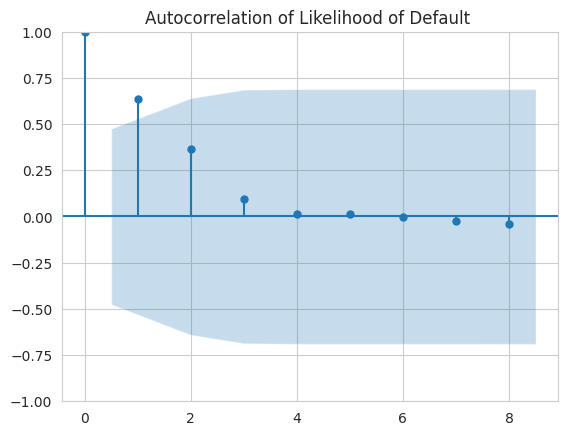

<Figure size 1000x600 with 0 Axes>

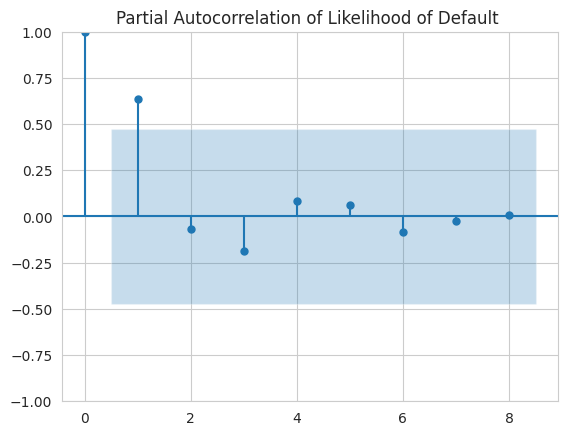

In [26]:
# Autocorrelation Plot for Likelihood of Default
plt.figure(figsize=(10, 6))
plot_acf(df_deflator['LIKELIHOODOFDEFAULT'], lags=8)
plt.title('Autocorrelation of Likelihood of Default ')
plt.show()

# Partial Autocorrelation Plot for Likelihood of Default
plt.figure(figsize=(10, 6))
plot_pacf(df_deflator['LIKELIHOODOFDEFAULT'], lags=8, method='ywm')
plt.title('Partial Autocorrelation of Likelihood of Default ')
plt.show()

# Transportation Cost Index (TCI) - monthly

In [27]:
df_tci = pd.read_csv('TCI_monthly_agg.csv')
df_tci.head()

,EXTRACTIONDATE,DATE,YEAR,MONTH,GLOSA,INDEX,Monthly_variation(%),LIKELIHOODOFDEFAULT
0,2024-03-23,2019-01-01,2019,1,ICT Sin Diésel,103.41,1.9,0.091579
1,2024-03-23,2019-02-01,2019,2,ICT Sin Diésel,101.26,-2.1,0.098561
2,2024-03-23,2019-03-01,2019,3,ICT Sin Diésel,99.60,-1.6,0.098208
3,2024-03-23,2019-04-01,2019,4,ICT Sin Diésel,99.95,0.4,0.096204
4,2024-03-23,2019-05-01,2019,5,ICT Sin Diésel,102.00,2.0,0.103981


In [28]:
# check if there is missing value
is_na_present = df_tci.isna().any().any()
print(f"There is any NA values in the DataFrame - {is_na_present}")

There is any NA values in the DataFrame - False


In [29]:
df_tci.dtypes

EXTRACTIONDATE           object
DATE                     object
YEAR                      int64
MONTH                     int64
GLOSA                    object
INDEX                   float64
Monthly_variation(%)    float64
LIKELIHOODOFDEFAULT     float64
dtype: object

In [30]:
# pick only TCI and Default Likelihood
df_tci_corr = df_tci[['INDEX', 'LIKELIHOODOFDEFAULT']]
df_tci_corr.head()

,INDEX,LIKELIHOODOFDEFAULT
0,103.41,0.091579
1,101.26,0.098561
2,99.60,0.098208
3,99.95,0.096204
4,102.00,0.103981


Basic Visualization

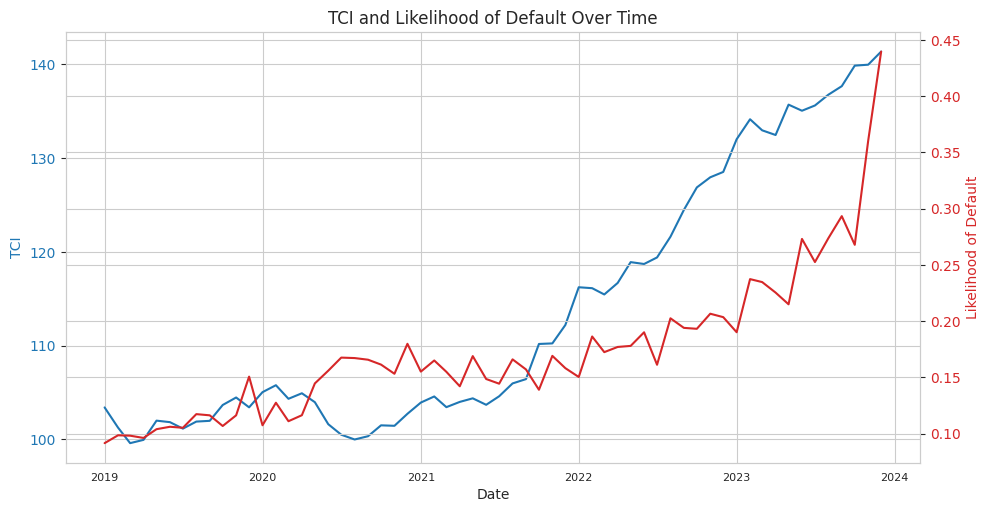

In [31]:
# TCI and Likelihood of Default Over Time

# Convert 'Date' column to datetime format
df_tci['DATE'] = pd.to_datetime(df_tci['DATE'])

fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('TCI', color=color)
ax1.plot(df_tci['DATE'], df_tci['INDEX'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax1.tick_params(axis='x', labelsize=8)

ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Likelihood of Default', color=color)  # We already handled the x-label with ax1
ax2.plot(df_tci['DATE'], df_tci['LIKELIHOODOFDEFAULT'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # To ensure tight layout so labels are not cut off
plt.title('TCI and Likelihood of Default Over Time')
plt.xticks(rotation=45)
plt.show()

Regression

In [32]:
# Compute the Pearson correlation coefficient
corr_coef = np.corrcoef(df_tci_corr['INDEX'], df_tci_corr['LIKELIHOODOFDEFAULT'])[0, 1]

# Prepare data for OLS regression
X = df_tci_corr['INDEX']
X = sm.add_constant(X)  # adding a constant to the model
y = df_tci_corr['LIKELIHOODOFDEFAULT']

# Fit OLS model
tci_model = sm.OLS(y, X).fit()

# Print the summary of the OLS model
print(tci_model.summary())

                             OLS Regression Results                            
Dep. Variable:     LIKELIHOODOFDEFAULT   R-squared:                       0.718
Model:                             OLS   Adj. R-squared:                  0.713
Method:                  Least Squares   F-statistic:                     147.7
Date:                 Tue, 02 Apr 2024   Prob (F-statistic):           1.38e-17
Time:                         23:43:44   Log-Likelihood:                 117.82
No. Observations:                   60   AIC:                            -231.6
Df Residuals:                       58   BIC:                            -227.5
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2817      0.038     -7.46

In [33]:
# Print the result
print(f"Model Pearson Correlation Coefficient: {corr_coef}")
print("Model R-squared: {:.3f}".format(tci_model.rsquared))

print("\nModel Coefficients:")
print(f"Intercept: {tci_model.params[0]:.3f}")
print(f"Slope (TCI): {tci_model.params[1]:.3f}")

print("\nModel P-values:")
print(f"P-value (Intercept): {tci_model.pvalues[0]:.3f}")
print(f"P-value (TCI): {tci_model.pvalues[1]:.3f}")

print("\nModel Standard Errors:")
print(f"Standard Error (Intercept): {tci_model.bse[0]:.3f}")
print(f"Standard Error (TCI): {tci_model.bse[1]:.3f}")

Model Pearson Correlation Coefficient: 0.8473982240364091
Model R-squared: 0.718

Model Coefficients:
Intercept: -0.282
Slope (TCI): 0.004

Model P-values:
P-value (Intercept): 0.000
P-value (TCI): 0.000

Model Standard Errors:
Standard Error (Intercept): 0.038
Standard Error (TCI): 0.000


Regression Visualization

In [34]:
sns.set_style("whitegrid")

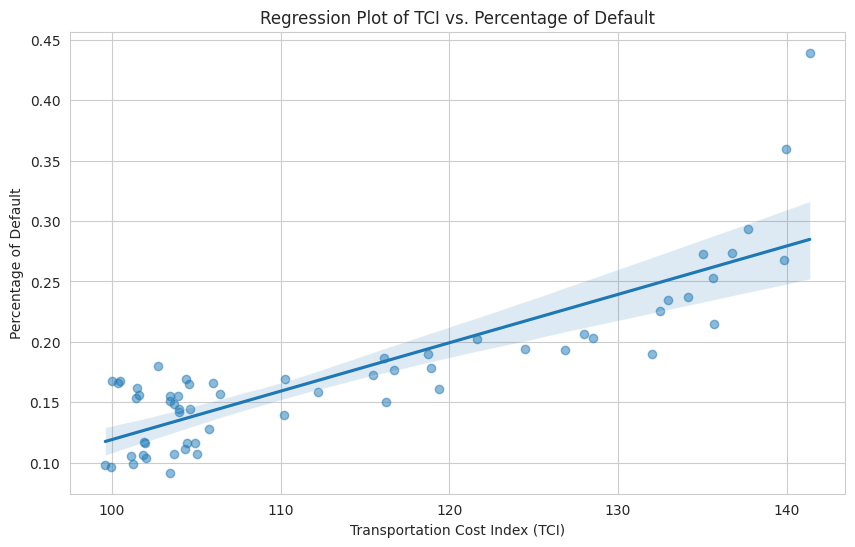

In [35]:
# Regression Plot
plt.figure(figsize=(10, 6))
sns.regplot(x='INDEX', y='LIKELIHOODOFDEFAULT', data=df_tci_corr, scatter_kws={'alpha':0.5})
plt.title('Regression Plot of TCI vs. Percentage of Default')
plt.xlabel('Transportation Cost Index (TCI)')
plt.ylabel('Percentage of Default')
plt.show()

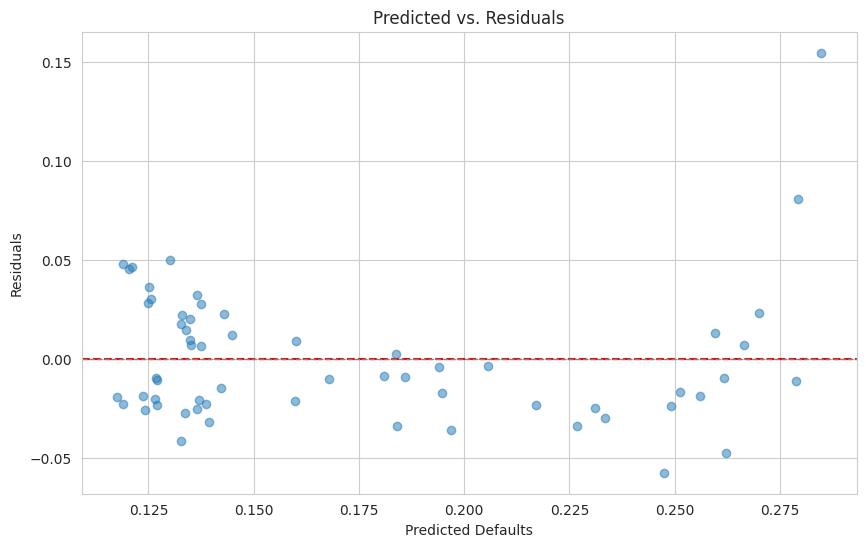

In [36]:
# Residual Plot
residuals = tci_model.resid
predicted = tci_model.fittedvalues

# Creating the plot
plt.figure(figsize=(10, 6))
plt.scatter(predicted, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Predicted vs. Residuals')
plt.xlabel('Predicted Defaults')
plt.ylabel('Residuals')

# Adding a zero line for reference
plt.axhline(0, linestyle='--', color='grey', linewidth=1)

plt.show()

Autocorrelation and Partial Autocorrelation Visualization

<Figure size 1000x600 with 0 Axes>

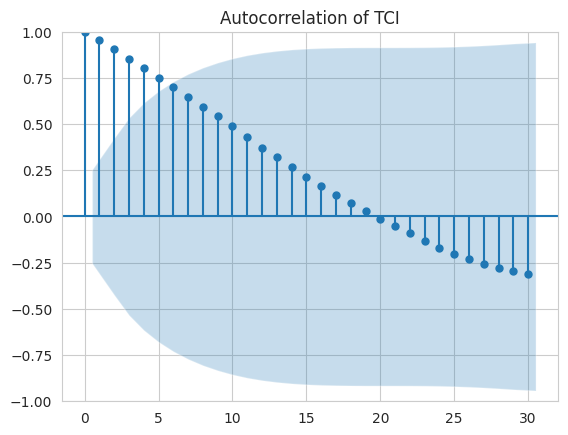

<Figure size 1000x600 with 0 Axes>

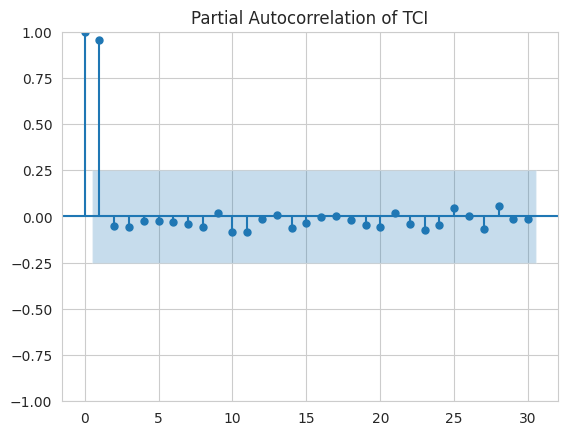

In [37]:
# Autocorrelation and Partial Autocorrelation
df_tci.set_index('DATE', inplace=True)

# Autocorrelation Plot for TCI
plt.figure(figsize=(10, 6))
plot_acf(df_tci['INDEX'], lags=30)
plt.title('Autocorrelation of TCI')
plt.show()

# Partial Autocorrelation Plot for TCI
plt.figure(figsize=(10, 6))
plot_pacf(df_tci['INDEX'], lags=30, method='ywm')
plt.title('Partial Autocorrelation of TCI')
plt.show()

<Figure size 1000x600 with 0 Axes>

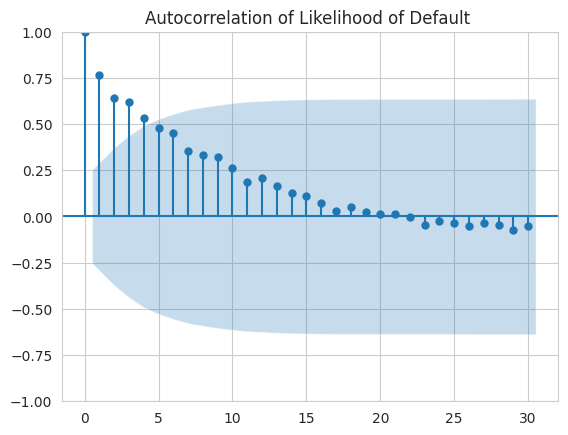

<Figure size 1000x600 with 0 Axes>

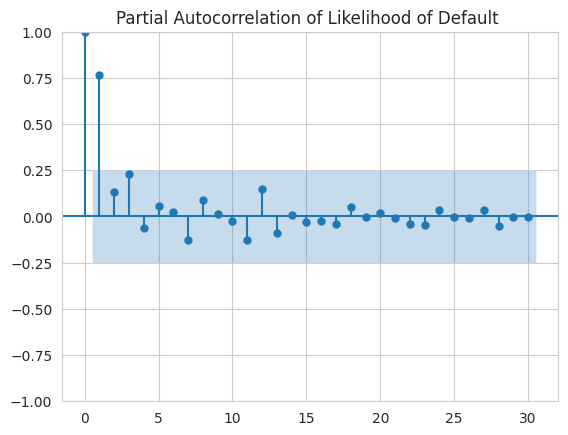

In [38]:
# Autocorrelation Plot for Likelihood of Default
plt.figure(figsize=(10, 6))
plot_acf(df_tci['LIKELIHOODOFDEFAULT'], lags=30)
plt.title('Autocorrelation of Likelihood of Default ')
plt.show()

# Partial Autocorrelation Plot for Likelihood of Default
plt.figure(figsize=(10, 6))
plot_pacf(df_tci['LIKELIHOODOFDEFAULT'], lags=30, method='ywm')
plt.title('Partial Autocorrelation of Likelihood of Default ')
plt.show()